
# Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [1]:
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
# data_path_arthur = ['/home/seaquest/Arthur/regularizar-metricas/']
# data_path_jonathan = ['']
#The filepath is dependent on the data_path set in the previous cell 
# filepath = os.sep.join(data_path_arthur + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
# filepath = os.sep.join(data_path_jonathan + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
#não precisou do path por estar no mesma pasta.

from __future__ import print_function
import os
import pandas as pd
import numpy as np

filepath = os.sep.join(['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [2]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [3]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [4]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [5]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [6]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

2141    3
6027    5
9946    2
3868    0
4784    0
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [8]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

In [9]:
data[feature_cols]

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,0.074472,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784
10295,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,0.101859,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412
10296,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.066249,-0.118854,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184
10297,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.046467,-0.205445,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563


A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

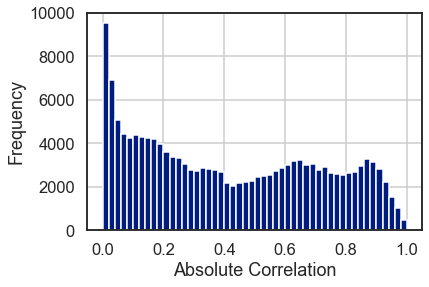

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']
print (X_train)

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
1575           0.354038          -0.032713          -0.130041   
1707           0.217986          -0.013950           0.006195   
6425           0.429555          -0.030768          -0.050656   
264            0.220094          -0.021543          -0.150737   
5972           0.280316          -0.017974          -0.107913   
...                 ...                ...                ...   
414            0.301743          -0.010642          -0.126631   
4138           0.225712          -0.015722          -0.105533   
3037           0.323819          -0.035463          -0.090467   
3002           0.165726          -0.027413          -0.064931   
996            0.278116          -0.019845          -0.110447   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
1575         -0.262424          0.213368          0.103241         -0.292688   
1707         -0.140788          0.312550         -0.309374       

In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

### Analyze Questions 4 to 9
## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression().fit(X_train, y_train)

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

### Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [18]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_train, y_train) #lbfgs (default)

#### Observações, Análises, 
Na questão quatro ele chama as funções/importa e depois manda rodar a regressão logística com 2 modelos diferentes, p/ fazer comparação.
não há nada além disso p/ ser analisado aqui, a não ser o fato de que as 2 regressões usadas foram a liblinear e a lbfgs que é a default.


## Question 5
### 5.1
Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [42]:
np.shape(lr.coef_)

(6, 561)

In [19]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    levels=[[lab], [0,1,2,3,4,5]]
    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
    coeff_label = pd.MultiIndex(levels,labels)
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                     l1  \
            0         1         2         3         4         5    0   
177 -0.017092  0.027137  0.085544 -0.099838  0.112802 -0.108554  0.0   
32   0.039896  0.358552 -0.453932  0.138319  0.128730 -0.211565  0.0   
394 -0.058105 -0.006884  0.034983 -0.093394  0.175829 -0.052430  0.0   
316 -0.014785  0.014685 -0.046940 -0.074649 -0.162947  0.284635  0.0   
161 -0.008621  0.005398  0.002340  0.132178  0.013442 -0.144738  0.0   
7   -0.072087 -0.058762 -0.213466  0.242460 -0.195565  0.297421  0.0   
415 -0.016284  0.036181  0.066480 -0.106775  0.191629 -0.171230  0.0   
153  0.094830  0.127658  0.018092 -0.121009 -0.441669  0.322097  0.0   
254 -0.059022 -0.102335  0.083623  0.101120  0.054953 -0.078340  0.0   
230 -0.080281  0.014223 -0.071691  0.122331 -0.232944  0.248361  0.0   

                                                             l2            \
            1         2         3         4         5         0         1   
177  0.000000  0.000000  0.000000  0.008314  0.338723 -0.069955 -0.008810   
32   2.398986 -2.531987  0.000000  0.000000 -5.592238  0.013162  0.891441   
394  0.000000  0.000000  0.000000  0.292942 -0.221624 -0.077482 -0.019136   
316  0.000000  0.000000  0.000000  0.000000  0.962081 -0.032085  0.009851   
161  0.000000  0.000000  0.248898  0.000000 -1.949697 -0.009000 -0.054590   
7    0.000000 -1.149809  0.000000  0.000000 -2.077732 -0.005005  0.141508   
415  0.000000  0.000000  0.000000  0.693568 -0.002259 -0.068106  0.012585   
153  0.000000  0.000000  0.000000 -0.573247  3.112128  0.087786  0.017289   
254  0.000000  0.000000  0.000000  0.000000 -0.124796 -0.066812 -0.225922   
230  0.000000  0.000000  0.000000  0.000000  0.975892 -0.085212  0.160219   

                                             
            2         3         4         5  
177  0.124910 -0.081033  0.103158 -0.068269  
32  -0.874267  0.059349  0.155428 -0.245113  
394  0.077538 -0.047869  0.129391 -0.062442  
316 -0.041468 -0.086157 -0.132415  0.282274  
161  0.078384  0.248510  0.043631 -0.306934  
7   -0.372767  0.258142 -0.248223  0.226344  
415  0.074934 -0.152602  0.296961 -0.163772  
153  0.162437 -0.286329 -0.413015  0.431831  
254  0.263902  0.084879  0.022744 -0.078791  
230 -0.224425  0.129558 -0.296590  0.316451

### 5.2 
Prepare six separate plots for each of the multi-class coefficients.

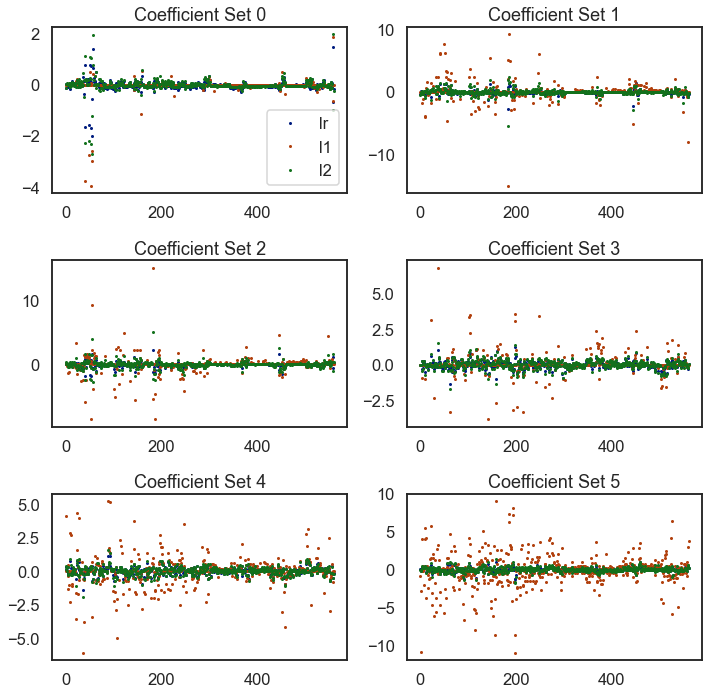

In [20]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


#### Observações, Análises, 

Na parte 51, ele faz uma tabela para comparar os resultados , para cada uma das regressões feitas, sendo lr a logistica, lr1 a logistica regularizada e lr2 a logistica regularizada com outro solver. 

SÃO 6 coeficientes p/ cada feature, são 500 e algo featuers, p/ cada uma delas teremos coeficientes que poderão indicar de que classe seria.

Temos então LABEl 0 a 5, p/ cada uma das regressões que são coeficientes de uma das 6 classes e nas linhas uma feature e sua correlação/coeficiente p/ resultado da classe. 

Já na parte 5.2 os valores de -5 a 5 p/ cada coeficiente, nos 3 casos e no eixo x seria p/ cada variavel, é bom fazer essas plotagens p/ poder ver quais coeficientes ficaram mais dispersos e mais próximos nas 3 regressões podendo ver a diferença clara entre cada caso, percebendo em qual das 3 regressões temos mais ou menos desparidades p/ classificar.


coef_ndarray of shape (1, n_features) or (n_classes, n_features)
Coefficient of the features in the decision function.

coef_ is of shape (1, n_features) when the given problem is binary.

coef_ no caso vai retornar um array do tipo (n_classes, n_features)
e o número de classes é 6, por isso 6 coeficientes.



In [21]:
np.shape(lr.coef_)

(6, 561)

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [22]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [23]:
y_prob.head()

,lr,l1,l2
0,0.999995,0.998917,0.999997
1,0.999237,0.999597,0.999726
2,0.997377,0.995675,0.998943
3,0.988750,0.999153,0.997738
4,0.995030,0.999924,0.999421


#### Observações, Análises, 

Nessa ele faz as predições do conjunto de validação/teste , de acordo com o que foi treinado no conjunto de treino, e monta duas tabelas, uma tabela que mostra a predição que foi feita por cada modelo, e uma que mostra a probabilidade que tinha p/ obter esse valor naquele caso em cada modelo p/ cada conjunto de features.

Importante resaltar que aparentemente tem haver os 0,1,2,3,4,5 das perguntas 4 e 5 com o que foi predito/adivinhado qual classe deve pertencer.

Acredito que a probabilidade é uma boa comparação p/ poder ver se está dentro de um erro "falso positivo", "falso negativo" tentando entender se o caso foi bem analisado com parametros futuros.





## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [27]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [28]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.980246,0.983514,0.983484
recall,0.980259,0.983495,0.983495
fscore,0.980248,0.983492,0.983489
accuracy,0.980259,0.983495,0.983495
auc,0.988042,0.989949,0.989975


## Question 8

Display or plot the confusion matrix for each model.

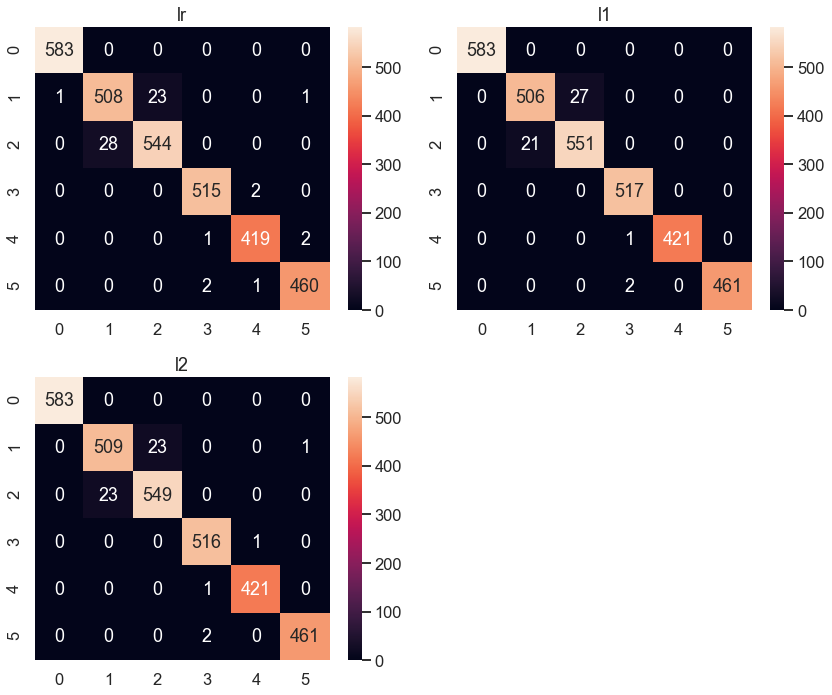

In [29]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7

sel = VarianceThreshold(threshold=(.7 * (1 - .7)))

data2 = pd.concat([X_train,X_test])
data_new = pd.DataFrame(sel.fit_transform(data2))


data_y = pd.concat([y_train,y_test])

from sklearn.model_selection import train_test_split

X_new,X_test_new = train_test_split(data_new)
Y_new,Y_test_new = train_test_split(data_y)

 Repeat Model building with new training data after removing higly correlated columns

In [31]:
# Try standard, L1 and L2 Logistic regression

In [32]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

### Implement 10 to 13
## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [33]:
# Combine all the coefficients into a dataframe for comparison


Prepare six separate plots for each of the multi-class coefficients.

In [34]:
# try the plots

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [35]:
# Predict the class and the probability for each


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [36]:
# Calculate the error metrics as listed above

In [37]:
#Run the metrics

## Question 13

Display or plot the confusion matrix for each model.

In [38]:
#plot the confusion matrix

In [39]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

In [40]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation